# Quantum Counselor for Portfolio Investment

The Quantum Counselor for portfolio investment is a tool with two main objectives: forecasting the trend of assets price and optimizing portfolio returns both using quantum computing techniques. For the case of the forecasting method, we use a hybrid method that combines a deep learning model of classical LSTM layers with quantum layers. For the case of portfolio optimization, the quantum algorithms of QAOA and VQE are used to solve the problem and will be compared with CPLEX, a classical solver. Both tools are deeply connected because the forecasted price of the different assets is used for the cost function construction.


## Portfolio optimization

For portfolio optimization, we use the modern portfolio theory where we is wanted to maximize the return of an investment while keeping the risk of losing money low. We based or method in the work of Mugel et. al [1] where the cost function is described by:

<center><img src="images/Cost-function.png" width="800"></center>


Two main techniques:

- Portfolio optimization using QAOA, VQE, and Cplex (for classical comparison).
- Hybrid model to predict the stocks prices


Here, it is found:

- Apply the results of the Hybrid model of price prediction to optimize the portfolio.

three scenarios XS (3 stocks, 2 periods), S (5 stocks, 3 periods), M (8, 4)

The solution methods are QAOA, VQE (both in qasm_simulator and the power-up qiskit machine with 16 qubits for XS and S), CPLEX.
Using SPSA and COBYLA as classic solvers for comparison and changing the number of repetitions in QAOA and the Ansatz in VQE.


[1] Mugel, S., Kuchkovsky, C., Sánchez, E., Fernández-Lorenzo, S., Luis-Hita, J., Lizaso, E., & Orús, R. (2022). Dynamic portfolio optimization with real datasets using quantum processors and quantum-inspired tensor networks. Physical Review Research, 4(1), 1–13. https://doi.org/10.1103/PhysRevResearch.4.013006

In [1]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
import matplotlib.pyplot as plt
import numpy as np
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer 
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit import IBMQ
from qiskit_optimization.runtime import QAOAClient, QAOAProgram
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.circuit.library import TwoLocal
import pandas as pd
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE, QAOA

### Functions developed by the authors

In [2]:
from portfolioFunctions import mu_fun, cov_matrix, portfolioOptimization, Optimization_QAOA, Optimization_VQE
from portfolioFunctions import profits, transaction_costs

# XS

The XS model consists of 3 assets and 2 periods of time with a maximum inversion per asset of 50% of the total budget.

In [3]:
# Set parameters for assets and risk factor
num_assets = 3     # set number of assets to 4
gamma = 0.5        # risk aversion to 0.5
K = 2              # total investment 
Lambda = 0.001
# Generate time series data
stocks = [("STOCK%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                          start=datetime.datetime(2010,1,1),   
                          end=datetime.datetime(2021,12,31))
data.run() 
# Data should contains the price of the action daily
# I should replace the part above by the information of Alberto
periods = 2
holding_period = 1 # Days of keeping the assets
max_invested = np.array(num_assets * [0.5])
dataN = np.array(data._data)
mu = holding_period * mu_fun(dataN, periods)
sigma = cov_matrix(dataN, periods)
qp = portfolioOptimization(mu, sigma, gamma, max_invested, Lambda=0, rho=5)
# Create a converter from quadratic program to quadratic unconstrained binary optimization (QUBO) representation
qubo = QuadraticProgramToQubo().convert(qp)

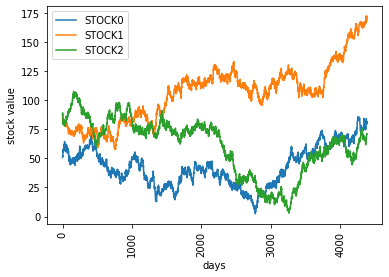

In [4]:
# Let's plot our finanical data
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('days')
plt.ylabel('stock value')
plt.show()

### QAOA Solution using SPSA and COBYLA

In [5]:
sol_qaoa_spsa, data_qaoa_spsa = Optimization_QAOA(qubo, reps=1, optimizer=SPSA(maxiter=50), local=True)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/utils/run_circuits.py:743: UserWarning: Option max_credits is not used by this backend
  return backend.run(circuits, **run_kwargs)


In [6]:
sol_qaoa_cobyla, data_qaoa_cobyla = Optimization_QAOA(qubo, reps=1, optimizer=COBYLA(maxiter=50), local=True)

In [7]:
provider = IBMQ.get_provider(hub='ibm-q-research', group='guanajuato-1',project='main')
backend = provider.get_backend("ibmq_jakarta")

In [ ]:
sol_qaoa_cobyla_rd, data_qaoa_cobyla_ed = Optimization_QAOA(qubo, reps=1, optimizer=COBYLA(maxiter=25),
                                                            provider=provider, backend=backend)

### VQE Solution using SPSA and SLSQP 

In [9]:
ansatz = TwoLocal(qubo.get_num_vars(), rotation_blocks='ry', entanglement_blocks='cz')
sol_vqe_slsqp, data_vqe_slsqp = Optimization_VQE(qubo, ansatz=ansatz, optimizer=SLSQP(maxiter=50), local=True)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/utils/run_circuits.py:743: UserWarning: Option max_credits is not used by this backend
  return backend.run(circuits, **run_kwargs)


In [10]:
sol_vqe_spsa, data_vqe_spsa = Optimization_VQE(qubo, ansatz=ansatz, optimizer=SPSA(maxiter=50), local=True)

## Solution using CPLEX

In [13]:
sol_cplex = CplexOptimizer().solve(qubo)

In [14]:
data_sx = [sol_qaoa_spsa, sol_qaoa_cobyla, sol_vqe_slsqp, sol_vqe_spsa,sol_cplex]
pd.DataFrame({"Method":["QAOA","QAOA", "VQE", "VQE", "CPLEX"],
                        "Solver":["SPSA", "COBYLA","SPSA", "SLSQP",""],
                        "Cost":[_.fval for _ in data_sx],
                        "Solution":[_.x for _ in data_sx],
                        "Profit":[np.round(profits(_.x, mu, Lambda, periods),4) for _ in data_sx],
                        "Transaction Cost":[transaction_costs(_.x, Lambda, periods) for _ in data_sx]
             })

,Method,Solver,Cost,Solution,Profit,Transaction Cost
0,QAOA,SPSA,0.000101,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0]","[-0.0015, 0.0003]","[0.002, 0.0]"
1,QAOA,COBYLA,0.000101,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0]","[-0.0015, 0.0003]","[0.002, 0.0]"
2,VQE,SPSA,0.000101,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0]","[-0.0015, 0.0003]","[0.002, 0.0]"
3,VQE,SLSQP,0.000101,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0]","[-0.0015, 0.0003]","[0.002, 0.0]"
4,CPLEX,,0.000101,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0]","[-0.0015, 0.0003]","[0.002, 0.0]"


## S

The S model consists of 5 assets and 3 periods of time with a maximum inversion per asset of 25% of the total budget.


In [16]:
# Set parameters for assets and risk factor
num_assets = 5     # set number of assets to 4
gamma = 0.5        # risk aversion to 0.5
Lambda = 0.001
# Generate time series data
stocks = [("STOCK%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                          start=datetime.datetime(2010,1,1),   
                          end=datetime.datetime(2021,12,31))
data.run() 
# Data should contains the price of the action daily
# I should replace the part above by the information of Alberto
periods = 3
holding_period = 1 # Days of keeping the assets
max_invested = np.array(num_assets * [0.25])
dataN = np.array(data._data)
mu = holding_period * mu_fun(dataN, periods)
sigma = cov_matrix(dataN, periods)
qp = portfolioOptimization(mu, sigma, gamma, max_invested, Lambda=0, rho=5)
# Create a converter from quadratic program to quadratic unconstrained binary optimization (QUBO) representation
qubo = QuadraticProgramToQubo().convert(qp)


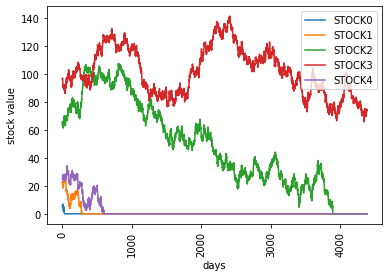

In [33]:
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('days')
plt.ylabel('stock value')
plt.show()

### QAOA Solution using SPSA and COBYLA

In [17]:
sol_qaoa_spsa, data_qaoa_spsa = Optimization_QAOA(qubo, reps=1, optimizer=SPSA(maxiter=50), local=True)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/utils/run_circuits.py:743: UserWarning: Option max_credits is not used by this backend
  return backend.run(circuits, **run_kwargs)


In [18]:
sol_qaoa_cobyla, data_qaoa_cobyla = Optimization_QAOA(qubo, reps=1, optimizer=COBYLA(maxiter=50), local=True)

### VQE Solution using SPSA and COBYLA

In [21]:
ansatz = TwoLocal(qubo.get_num_vars(), rotation_blocks='ry', entanglement_blocks='cz')
sol_vqe_slsqp, data_vqe_slsqp = Optimization_VQE(qubo, ansatz=ansatz, optimizer=COBYLA(maxiter=50), local=True)

In [20]:
sol_vqe_spsa, data_vqe_spsa = Optimization_VQE(qubo, ansatz=ansatz, optimizer=SPSA(maxiter=50), local=True)

### Solution using CPLEX

In [22]:
sol_cplex = CplexOptimizer().solve(qubo)

In [32]:
data_s = [sol_qaoa_spsa, sol_qaoa_cobyla, sol_vqe_slsqp, sol_vqe_spsa,sol_cplex]
pd.DataFrame({"Method":["QAOA","QAOA", "VQE", "VQE", "CPLEX"],
                        "Solver":["SPSA", "COBYLA","SPSA", "COBYLA",""],
                        "Cost":[_.fval for _ in data_s],
                        "Solution":[_.x.reshape(periods,-1).astype(int) for _ in data_s],
                        "Profit":[np.round(profits(_.x, mu, Lambda, periods),4) for _ in data_s],
                        "Transaction Cost":[transaction_costs(_.x, Lambda, periods) for _ in data_s]
             })

,Method,Solver,Cost,Solution,Profit,Transaction Cost
0,QAOA,SPSA,0.000742,"[[1, 1, 0, 1, 1], [1, 0, 1, 1, 1], [1, 1, 1, 1...","[-0.0027, -0.0021, -0.0032]","[0.004, 0.002, 0.002]"
1,QAOA,COBYLA,-0.000101,"[[0, 1, 1, 1, 1], [1, 1, 1, 0, 1], [1, 1, 0, 1...","[-0.0007, -0.0023, -0.0022]","[0.004, 0.002, 0.002]"
2,VQE,SPSA,0.312399,"[[0, 1, 1, 1, 1], [1, 1, 1, 0, 1], [0, 1, 0, 1...","[-0.0007, -0.0023, -0.0032]","[0.004, 0.002, 0.003]"
3,VQE,COBYLA,-0.000101,"[[0, 1, 1, 1, 1], [1, 1, 1, 0, 1], [1, 1, 0, 1...","[-0.0007, -0.0023, -0.0022]","[0.004, 0.002, 0.002]"
4,CPLEX,,-0.000232,"[[0, 1, 1, 1, 1], [1, 1, 0, 1, 1], [1, 1, 0, 1...","[-0.0007, -0.0018, -0.0002]","[0.004, 0.002, 0.0]"
